In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
import os
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv


from sustaingym.envs.battery.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv
from sustaingym.envs.battery.plot_utils import plot_model_training_reward_curves, plot_reward_distribution, plot_state_of_charge_and_prices, plot_reward_over_episode, run_model_for_evaluation

In [20]:
class SaveActionsExperienced(BaseCallback):
    def __init__(self, log_dir: str, verbose: int = 1):
        super(SaveActionsExperienced, self).__init__(verbose)
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'actions')
        self.constructed_log = False
        self.time_steps = []
        self.training_selling_prices = []
        self.training_buying_prices = []
        self.training_energy_lvl = []
        self.training_dispatch = []
    
    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self) -> bool:
        env = self.training_env
        obs = env.get_attr('obs', 0)[0] # get current observation from the vectorized env
        # count = env.get_attr('count', 0)[0]
        prev_action = obs['previous action']
        energy_lvl = obs['energy'][0]
        dispatch = obs['previous agent dispatch'][0]

        # print('step: ', count)
        # print('selling price: ', prev_action[0])
        # print('buying price: ', prev_action[1])

        self.time_steps.append(self.num_timesteps)
        self.training_selling_prices.append(prev_action[0])
        self.training_buying_prices.append(prev_action[1])
        self.training_energy_lvl.append(energy_lvl)
        self.training_dispatch.append(dispatch)

        if not self.constructed_log:
            # first_row = np.array([count, prev_action[0], prev_action[1]])
            # df = pd.DataFrame({'Step': first_row[0], 'Selling Price': first_row[1],
            #                 'Buying Price': first_row[2]}, index=[0])
            # df.to_csv(f'{self.save_path}/action_log.csv', sep='\t', encoding='utf-8', index=False)
            np.savez(f'{self.save_path}/action_log',
                step=self.time_steps,
                selling_price=self.training_selling_prices,
                buying_price=self.training_buying_prices,
                energy_lvl=self.training_energy_lvl,
                dispatch=self.training_dispatch)
            
            self.constructed_log = True

        else:
            # curr_row = np.array([count, prev_action[0], prev_action[1]])
            # df = pd.read_csv(f'{self.save_path}/action_log.csv', sep='\t', encoding='utf-8')
            # df.loc[len(df)] = curr_row
            # df.to_csv(f'{self.save_path}/action_log.csv', sep='\t', encoding='utf-8', index=False)

            np.savez(f'{self.save_path}/action_log',
                step=self.time_steps,
                selling_price=self.training_selling_prices,
                buying_price=self.training_buying_prices,
                energy_lvl=self.training_energy_lvl,
                dispatch=self.training_dispatch)
    
        return True 

save_path = os.path.join(os.getcwd(), 'logs_PPO/')
model_save_path = os.path.join(os.getcwd(), 'model_PPO_2019_5')

env_2019 = BatteryStorageInGridEnv(month='2019-05', seed=195)
env_2021 = BatteryStorageInGridEnv(month='2021-05', seed=215)

# rescale action spaces to normalized [0,1] interval
wrapped_env_2019 = gym.wrappers.RescaleAction(env_2019, min_action=0, max_action=1)
wrapped_env_2021 = gym.wrappers.RescaleAction(env_2021, min_action=0, max_action=1)

save_path_in_dist = os.path.join(save_path, 'in_dist/')
save_path_out_dist = os.path.join(save_path, 'out_dist/')

steps_per_ep = wrapped_env_2019.MAX_STEPS_PER_EPISODE

log_actions_callback = SaveActionsExperienced(log_dir=save_path)
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback_in_dist = EvalCallback(wrapped_env_2019, best_model_save_path=save_path_in_dist,
log_path=save_path_in_dist, eval_freq=10*steps_per_ep, callback_after_eval=stop_train_callback)
eval_callback_out_dist = EvalCallback(wrapped_env_2021, best_model_save_path=save_path_out_dist,
log_path=save_path_out_dist, eval_freq=10*steps_per_ep)
callback_list = CallbackList([log_actions_callback, eval_callback_in_dist, eval_callback_out_dist])

model = PPO("MultiInputPolicy", wrapped_env_2019, gamma=0.995, verbose=1)
print("Training model")
model.learn(int(steps_per_ep), callback=callback_list)
print("\nTraining finished. \n")
print("----- ----- ----- -----")
print("----- ----- ----- -----")
model.save(os.path.join(model_save_path))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training model
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 287       |
|    ep_rew_mean     | -1.97e+04 |
| time/              |           |
|    fps             | 44        |
|    iterations      | 1         |
|    time_elapsed    | 46        |
|    total_timesteps | 2048      |
----------------------------------

Training finished. 

----- ----- ----- -----
----- ----- ----- -----


In [3]:
save_path = os.path.join(os.getcwd(), 'logs_PPO/actions')

results = np.load(f'{save_path}/action_log.npz')
time_steps = results['step']
sell_prices = results['selling_price']
buy_prices = results['buying_price']
energy_lvls = results['energy_lvl']
disbatches= results['dispatch']

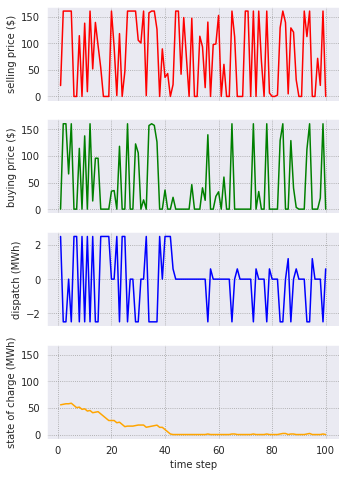

In [5]:
# time_steps = np.arange(1, len(steps) + 1)
# fig, (ax, ax2, ax3) = plt.subplots(3)

# ax.plot(time_steps[:100], sell_prices[:100], color='red')
# ax2.plot(time_steps[:100], buy_prices[:100], color='green')
# ax3.plot(time_steps[:100], energy_lvls[:100], color='blue')

# # naming the x axis 
# ax2.set_xlabel('time step')
# # naming the y axis 
# ax.set_ylabel('selling price ($)')
# ax2.set_ylabel('buying price ($)')
# ax3.set_ylabel('state of charge (MWh)')

ax1 = plt.subplot(411)
plt.plot(time_steps[:100], sell_prices[:100], color='red')
plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
ax2 = plt.subplot(412, sharex=ax1)
plt.plot(time_steps[:100], buy_prices[:100], color='green')
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

# share x only
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(time_steps[:100], disbatches[:100], color='blue')
# make these tick labels invisible
plt.setp(ax3.get_xticklabels(), visible=False)

# share x and y
ax4 = plt.subplot(414, sharex=ax1, sharey=ax1)
plt.plot(time_steps[:100], energy_lvls[:100], color='orange')

# naming the x axis 
ax4.set_xlabel('time step')
# naming the y axis 
ax1.set_ylabel('selling price ($)')
ax2.set_ylabel('buying price ($)')
ax3.set_ylabel('dispatch (MWh)')
ax4.set_ylabel('state of charge (MWh)')

plt.subplots_adjust(bottom=0, right=0.8, top=1.5)
plt.show()